<a href="https://colab.research.google.com/github/kodegut/SwiftForTensorFlow/blob/main/IrisFlowerClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Iris Flower Classification with Swift
## Ongoing training project...
A classic dataset when approaching TensorFlow or machine learning in general is the iris_training set.
You can find a detailed description in this walkthrough, which also serves as the basis for this notebooks content:

https://colab.research.google.com/github/tensorflow/swift/blob/main/docs/site/tutorials/model_training_walkthrough.ipynb 

**In short:** We are trying to classify iris flowers based on the measurements of their sepals (Kelchblätter) and petals (Blütenblätter) and this time we do it with Swift.

In [1]:
import TensorFlow

// Swift framework to interact with Python:
import PythonKit

2021-01-17 10:23:31.821610: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1


In [2]:
// This cell is here to display the plots in a Jupyter Notebook.
// Do not copy it into another environment.
%include "EnableIPythonDisplay.swift"
print(IPythonDisplay.shell.enable_matplotlib("inline"))

('inline', 'module://ipykernel.pylab.backend_inline')


In [3]:
let plt = Python.import("matplotlib.pyplot")

## Brief Insertion 1

Before I go on with the walkthrough I want to explore the basics for TensorFlow in Swift. Let's start with basic tensors.

For further reference: https://www.tensorflow.org/swift/api_docs

In [4]:
// Create a [2,2] Tensor
// In Python: tensor = tf.constant([[1.0, 0.0], [0.0, 1.0]])
// In Swift:
let tensor = Tensor<Float>([[1, 0], [0, 1]])

// Elements can be accessed like a swift array
print("Entry at index [1][0]: \(tensor[1][0]) \n")

// After we have created our tensor we can use the usual methods
print("Shape of our Tensor: \(tensor.shape)\n")
print("Index of the largest value: \(tensor.argmax())\n")

// However they might have changed a little
print("Our Tensor as an array: \n \(tensor.makeNumpyArray()) \n")

// Calculations work sometimes
print("Addition: \n \(tensor + tensor) \n")
print("Multiplication 1: \n \(tensor * tensor) \n")
print("Multiplication 2: \n \(multiply(tensor, tensor)) \n")

// However not always in the same way
// e.g. "tensor @ tensor" does not work
print("Matrix Multiplication: \n \(matmul(tensor,tensor)) \n")

// I didn't find a (short) solution for the following problem
// In Python tf.tensordot() 
print("How to do Scalar Product?: \n ? \n")



2021-01-17 10:23:36.773768: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN)to use the following CPU instructions in performance-critical operations:  SSE3 SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-01-17 10:23:36.812338: I tensorflow/core/platform/profile_utils/cpu_utils.cc:104] CPU Frequency: 2299995000 Hz
2021-01-17 10:23:36.812899: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0xf20000 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2021-01-17 10:23:36.812964: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2021-01-17 10:23:36.890217: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcuda.so.1
2021-01-17 10:23:36.959433: E tensorflow/stream_executor/cuda/c

## Let's go on with the iris classification

First we load the training data:

In [5]:
import Foundation
import FoundationNetworking

func download(from sourceString: String, to destinationString: String) {
    let source = URL(string: sourceString)!
    let destination = URL(fileURLWithPath: destinationString)
    let data = try! Data.init(contentsOf: source)
    try! data.write(to: destination)
}

In [19]:
let trainDataFilename = "iris_training.csv"
download(from: "http://download.tensorflow.org/data/iris_training.csv", to: trainDataFilename)


In [7]:
let featureNames = ["sepal_length", "sepal_width", "petal_length", "petal_width"]
let labelName = "species"
let columnNames = featureNames + [labelName]
let classNames = ["Iris setosa", "Iris versicolor", "Iris virginica"]

print("Features: \(featureNames)")
print("Label: \(labelName)")

Features: ["sepal_length", "sepal_width", "petal_length", "petal_width"]
Label: species


## Brief Insertion 2

While I get we want to do this with Swift, I guess we can also do it easier using the keras wrapper (I guess the performance benefits of swift don't come into play yet when loading CSVs anyways). So let's see in the next block:

In [28]:
// Alternative with Python + keras + panda
let keras = Python.import("keras")
let pd = Python.import("pandas")
let trainCSV = keras.utils.get_file(
    "iris_training.csv", "https://download.tensorflow.org/data/iris_training.csv")

let train = pd.read_csv(trainCSV, names:featureNames, header:0)

print(train.head())

     sepal_length  ...  petal_width
6.4           2.8  ...            2
5.0           2.3  ...            1
4.9           2.5  ...            2
4.9           3.1  ...            0
5.7           3.8  ...            0

[5 rows x 4 columns]


## And we go on
With batching the training set:

In [8]:
let batchSize = 32

/// A batch of examples from the iris dataset.
struct IrisBatch {
    /// [batchSize, featureCount] tensor of features.
    let features: Tensor<Float>

    /// [batchSize] tensor of labels.
    let labels: Tensor<Int32>
}

/// Conform `IrisBatch` to `Collatable` so that we can load it into a `TrainingEpoch`.
extension IrisBatch: Collatable {
    public init<BatchSamples: Collection>(collating samples: BatchSamples)
        where BatchSamples.Element == Self {
        /// `IrisBatch`es are collated by stacking their feature and label tensors
        /// along the batch axis to produce a single feature and label tensor
        features = Tensor<Float>(stacking: samples.map{$0.features})
        labels = Tensor<Int32>(stacking: samples.map{$0.labels})
    }
}

In [9]:
/// Initialize an `IrisBatch` dataset from a CSV file.
func loadIrisDatasetFromCSV(
        contentsOf: String, hasHeader: Bool, featureColumns: [Int], labelColumns: [Int]) -> [IrisBatch] {
        let np = Python.import("numpy")

        let featuresNp = np.loadtxt(
            contentsOf,
            delimiter: ",",
            skiprows: hasHeader ? 1 : 0,
            usecols: featureColumns,
            dtype: Float.numpyScalarTypes.first!)
        guard let featuresTensor = Tensor<Float>(numpy: featuresNp) else {
            // This should never happen, because we construct featuresNp in such a
            // way that it should be convertible to tensor.
            fatalError("np.loadtxt result can't be converted to Tensor")
        }

        let labelsNp = np.loadtxt(
            contentsOf,
            delimiter: ",",
            skiprows: hasHeader ? 1 : 0,
            usecols: labelColumns,
            dtype: Int32.numpyScalarTypes.first!)
        guard let labelsTensor = Tensor<Int32>(numpy: labelsNp) else {
            // This should never happen, because we construct labelsNp in such a
            // way that it should be convertible to tensor.
            fatalError("np.loadtxt result can't be converted to Tensor")
        }

        return zip(featuresTensor.unstacked(), labelsTensor.unstacked()).map{IrisBatch(features: $0.0, labels: $0.1)}

    }

In [10]:
let trainingDataset: [IrisBatch] = loadIrisDatasetFromCSV(contentsOf: trainDataFilename, 
                                                  hasHeader: true, 
                                                  featureColumns: [0, 1, 2, 3], 
                                                  labelColumns: [4])

let trainingEpochs: TrainingEpochs = TrainingEpochs(samples: trainingDataset, batchSize: batchSize)

In [11]:
let firstTrainEpoch = trainingEpochs.next()!
let firstTrainBatch = firstTrainEpoch.first!.collated
let firstTrainFeatures = firstTrainBatch.features
let firstTrainLabels = firstTrainBatch.labels

//print("First batch of features: \(firstTrainFeatures)")
//print("firstTrainFeatures.shape: \(firstTrainFeatures.shape)")
//print("First batch of labels: \(firstTrainLabels)")
//print("firstTrainLabels.shape: \(firstTrainLabels.shape)")

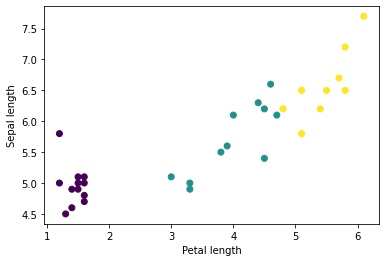

Use `print()` to show values.


In [12]:
let firstTrainFeaturesTransposed = firstTrainFeatures.transposed()
let petalLengths = firstTrainFeaturesTransposed[2].scalars
let sepalLengths = firstTrainFeaturesTransposed[0].scalars

plt.scatter(petalLengths, sepalLengths, c: firstTrainLabels.array.scalars)
plt.xlabel("Petal length")
plt.ylabel("Sepal length")
plt.show()

In [13]:
let hiddenSize: Int = 10
struct IrisModel: Layer {
    var layer1 = Dense<Float>(inputSize: 4, outputSize: hiddenSize, activation: relu)
    var layer2 = Dense<Float>(inputSize: hiddenSize, outputSize: hiddenSize, activation: relu)
    var layer3 = Dense<Float>(inputSize: hiddenSize, outputSize: 3)
    
    @differentiable
    func callAsFunction(_ input: Tensor<Float>) -> Tensor<Float> {
        return input.sequenced(through: layer1, layer2, layer3)
    }
}

var model = IrisModel()